# Sliding Cache window

by
> B Srinath 2023122002
> 

## Modules to Import

In [ ]:
# Model Pulling
from transformers import AutoTokenizer, AutoModelForCausalLM

# Analysis
import torch
import time
import matplotlib.pyplot as plt

/home/sriney/miniconda3/envs/hawai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Pulling

In [3]:
# Define the model you want to download.
model_name = "gpt2"

print(f"--- Downloading model: {model_name} ---")
print("This may take a few moments depending on your internet connection.")

# By calling 'from_pretrained', the library checks the local cache.
# If the model isn't there, it downloads and saves it.
# If it is there, it does nothing.
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

print("\nModel and tokenizer are downloaded and cached successfully.")

--- Downloading model: gpt2 ---
This may take a few moments depending on your internet connection.

Model and tokenizer are downloaded and cached successfully.


## Model Inference Test

In [ ]:
# --- Configuration ---
# Define the model to use (should match the one you downloaded).
model_name = "gpt2"
# Define the input text for the model.
prompt = "The future of artificial intelligence is"

# --- Load and Run ---
print(f"Loading model '{model_name}' from local cache...")
# This will be fast because the model is already downloaded.
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

print("Running inference...")
# Encode the prompt and generate the output text.
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(
    inputs["input_ids"],
    max_length=50,
    pad_token_id=tokenizer.eos_token_id
)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# --- Print the Result ---
print("\n--- Generated Text ---")
print(generated_text)

Loading model 'gpt2' from local cache...
Running inference...

--- Generated Text ---
The future of artificial intelligence is uncertain.

"We're not sure what the future will look like," said Dr. Michael S. Schoenfeld, a professor of computer science at the University of California, Berkeley. "But we're not


# Cuda Check and model loading

In [6]:
# --- Configuration ---
device = "cuda" if torch.cuda.is_available() else "cpu"
# CHANGE: Use a larger model to increase GPU workload and cache size.
model_name = "gpt2-large"
# CHANGE: Generate up to the model's max context length to see the full effect.
generation_length = 1024 

print(f"Using device: {device}")
print(f"Loading model: {model_name}")

# --- Load Model and Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

print("Setup complete.")

Using device: cuda
Loading model: gpt2-large
Setup complete.


## Analysis Function 

In [7]:
def analyze_inference(strategy, window_size=None):
    """
    Generates tokens one-by-one and records the time taken for each.

    Args:
        strategy (str): 'baseline' or 'sliding_window'.
        window_size (int, optional): The window size for the sliding window strategy.
    """
    print(f"\n--- Running test for strategy: '{strategy}' ---")
    
    # Start with a single "beginning of sentence" token
    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    past_key_values = None
    timings = []
    
    with torch.no_grad():
        for i in range(generation_length):
            start_time = time.perf_counter()

            # Model forward pass
            outputs = model(input_ids=input_ids[:, -1:], past_key_values=past_key_values, use_cache=True)
            
            # Get the next predicted token
            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(-1)
            
            # Append the new token for the next iteration
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            
            past_key_values = outputs.past_key_values

            # --- This is the Sliding Window Implementation ---
            if strategy == 'sliding_window' and past_key_values is not None:
                # After each step, trim the cache to the window size
                trimmed_past = []
                for layer_past in past_key_values:
                    # Trim the sequence length dimension (dim 2)
                    trimmed_key = layer_past[0][:, :, -window_size:, :]
                    trimmed_value = layer_past[1][:, :, -window_size:, :]
                    trimmed_past.append((trimmed_key, trimmed_value))
                past_key_values = tuple(trimmed_past)
            
            end_time = time.perf_counter()
            timings.append((end_time - start_time) * 1000)  # Store time in milliseconds

            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length} tokens...")
    
    print(f"'{strategy}' test complete.")
    return timings

In [8]:
# --- Experiment 1: Baseline (Without Optimization) ---
# The cache will grow up to the full generation length.
baseline_timings = analyze_inference(strategy='baseline')

# --- Experiment 2: Sliding Window (With Optimization) ---
# We cap the cache size at 128 tokens.
sliding_window_timings = analyze_inference(strategy='sliding_window', window_size=128)


--- Running test for strategy: 'baseline' ---
Generated 100/1024 tokens...
Generated 200/1024 tokens...
Generated 300/1024 tokens...
Generated 400/1024 tokens...
Generated 500/1024 tokens...
Generated 600/1024 tokens...
Generated 700/1024 tokens...
Generated 800/1024 tokens...
Generated 900/1024 tokens...
Generated 1000/1024 tokens...
'baseline' test complete.

--- Running test for strategy: 'sliding_window' ---
Generated 100/1024 tokens...
Generated 200/1024 tokens...
Generated 300/1024 tokens...
Generated 400/1024 tokens...
Generated 500/1024 tokens...
Generated 600/1024 tokens...
Generated 700/1024 tokens...
Generated 800/1024 tokens...
Generated 900/1024 tokens...
Generated 1000/1024 tokens...
'sliding_window' test complete.


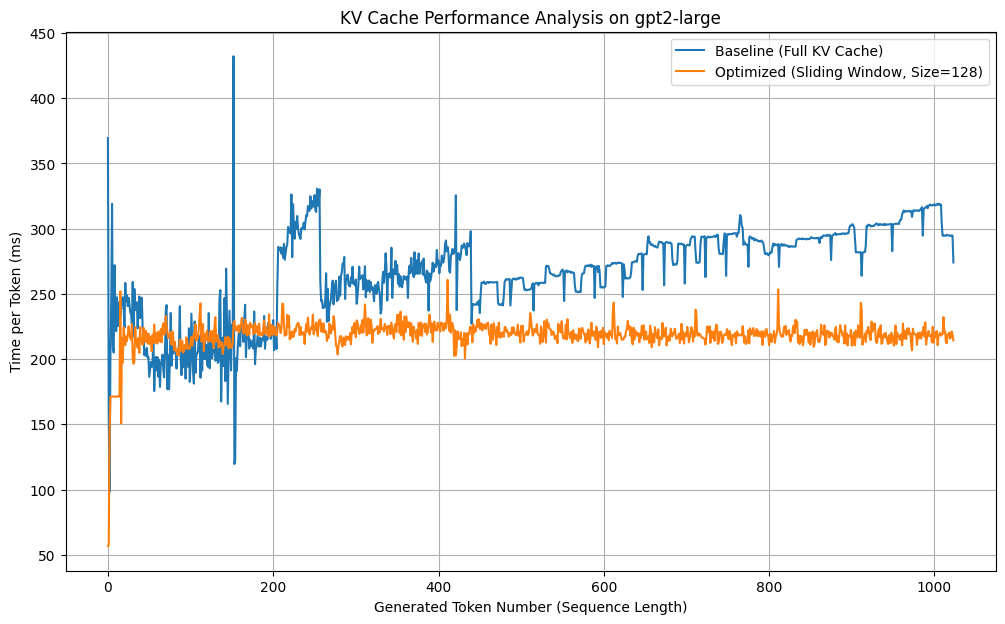

In [9]:
plt.figure(figsize=(12, 7))
plt.plot(baseline_timings, label='Baseline (Full KV Cache)')
plt.plot(sliding_window_timings, label='Optimized (Sliding Window, Size=128)')
plt.xlabel('Generated Token Number (Sequence Length)')
plt.ylabel('Time per Token (ms)')
plt.title(f'KV Cache Performance Analysis on {model_name}')
plt.legend()
plt.grid(True)
plt.show()